# Recurrent Neural Network - LSTM


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
import os

### Importar a base de dados

In [2]:
# Foi utilizada a base de dados de cotação de ações da Petrobras (PETR4)
# O período analisado vai de 23/05/2020 a 23/05/2023
# A série temporal foi dividida em treino (30%) e teste (70%)

In [3]:
PETR4_data = pd.read_csv('PETR4.csv')

In [4]:
PETR4_data_train = PETR4_data.iloc[1:249, 0:2].values

In [5]:
PETR4_data_test= PETR4_data.iloc[249:747, 0:2].values

In [6]:
training_set = PETR4_data.iloc[0:249, 1:2].values

In [7]:
test_set = PETR4_data.iloc[249:747,1:2]

### Parâmetros para esta análise

In [8]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 100
units2 = 60
units3 = 30

### Normalização

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [10]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [11]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [13]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [15]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 15, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 60)            38640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                10920     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

### Treinamento

In [16]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1133
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0335
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0308
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0193
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0258
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0229
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0205
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0206
Epoch 9/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0212
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0215
Epoch 11/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0181
Epoch 12/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0163
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [17]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [18]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [19]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

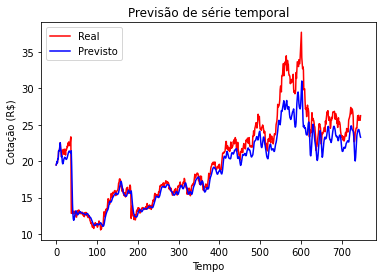

In [20]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [21]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.3816362933476136


In [22]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 5.672191433790561


In [23]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 6.948755186187344 %


In [24]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.7691799991531106


In [25]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.7687146362481774


In [26]:
results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [27]:
print(results)

[100.          60.          30.           2.38163629   5.67219143
   6.94875519   0.76918      0.76871464]


### Parâmetros para esta análise

In [28]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 100
units2 = 60
units3 = 50

### Normalização

In [29]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [30]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [31]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [32]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [33]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [35]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 15, 100)           40800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 60)            38640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 60)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                22200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

### Treinamento

In [36]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1105
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0343
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0307
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0241
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0274
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0206
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0207
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0196
Epoch 9/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0196
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0189
Epoch 11/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0194
Epoch 12/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0185
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [37]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [38]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [39]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

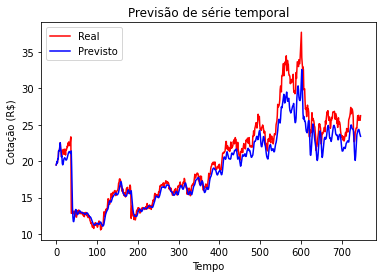

In [40]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [41]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.121679422890634


In [42]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 4.501523573517533


In [43]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 6.566623053642069 %


In [44]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.8168182990331043


In [45]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.8164489810876066


In [46]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [47]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [48]:
results = np.column_stack((results, data))

In [49]:
print(results)

[[100.         100.        ]
 [ 60.          60.        ]
 [ 30.          50.        ]
 [  2.38163629   2.12167942]
 [  5.67219143   4.50152357]
 [  6.94875519   6.56662305]
 [  0.76918      0.8168183 ]
 [  0.76871464   0.81644898]]


### Parâmetros para esta análise

In [50]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 100
units2 = 60
units3 = 70

### Normalização

In [51]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [52]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [53]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [54]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [55]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [56]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [57]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 15, 100)           40800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 15, 60)            38640     
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 60)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 70)                36680     
_________________________________________________________________
dropout_8 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

### Treinamento

In [58]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 18ms/step - loss: 0.1098
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0278
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0248
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0283
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0229
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0223
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0202
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0192
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0197
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0187
Epoch 11/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0165
Epoch 12/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0189
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [59]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [60]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [61]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

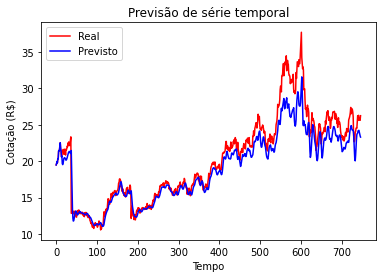

In [62]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [63]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.3179480597300355


In [64]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 5.372883207606236


In [65]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 6.91097834134094 %


In [66]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.7813598287353394


In [67]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.7809190219384348


In [68]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [69]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [70]:
results = np.column_stack((results, data))

In [71]:
print(results)

[[100.         100.         100.        ]
 [ 60.          60.          60.        ]
 [ 30.          50.          70.        ]
 [  2.38163629   2.12167942   2.31794806]
 [  5.67219143   4.50152357   5.37288321]
 [  6.94875519   6.56662305   6.91097834]
 [  0.76918      0.8168183    0.78135983]
 [  0.76871464   0.81644898   0.78091902]]


### Parâmetros para esta análise

In [72]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 100
units2 = 80
units3 = 30

### Normalização

In [73]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [74]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [75]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [76]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [77]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [78]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [79]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 15, 100)           40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 15, 80)            57920     
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30)                13320     
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### Treinamento

In [80]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0914
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0322
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0244
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0284
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0255
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0223
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0232
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0209
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0204
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0216
Epoch 11/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0166
Epoch 12/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0174
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [81]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [82]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [83]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

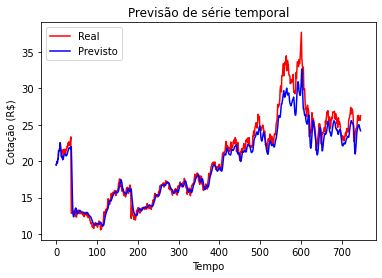

In [84]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [85]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 1.6483174789783555


In [86]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 2.716950511505561


In [87]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 4.69007689920099 %


In [88]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.8894384072387381


In [89]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.8892155008017195


In [90]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [91]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [92]:
results = np.column_stack((results, data))

In [93]:
print(results)

[[100.         100.         100.         100.        ]
 [ 60.          60.          60.          80.        ]
 [ 30.          50.          70.          30.        ]
 [  2.38163629   2.12167942   2.31794806   1.64831748]
 [  5.67219143   4.50152357   5.37288321   2.71695051]
 [  6.94875519   6.56662305   6.91097834   4.6900769 ]
 [  0.76918      0.8168183    0.78135983   0.88943841]
 [  0.76871464   0.81644898   0.78091902   0.8892155 ]]


### Parâmetros para esta análise

In [94]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 100
units2 = 80
units3 = 50

### Normalização

In [95]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [96]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [97]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [98]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [99]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [100]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [101]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 15, 100)           40800     
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 15, 80)            57920     
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

### Treinamento

In [102]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0791
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0275
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0237
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0245
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0213
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0203
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0178
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0178
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0207
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0205
Epoch 11/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0171
Epoch 12/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0185
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [103]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [104]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [105]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

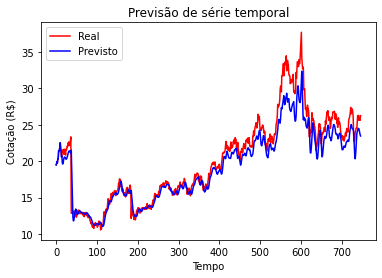

In [106]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [107]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.069287290134935


In [108]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 4.281949889113982


In [109]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 6.212361011705222 %


In [110]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.8257534696125135


In [111]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.8254021661238291


In [112]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [113]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [114]:
results = np.column_stack((results, data))

In [115]:
print(results)

[[100.         100.         100.         100.         100.        ]
 [ 60.          60.          60.          80.          80.        ]
 [ 30.          50.          70.          30.          50.        ]
 [  2.38163629   2.12167942   2.31794806   1.64831748   2.06928729]
 [  5.67219143   4.50152357   5.37288321   2.71695051   4.28194989]
 [  6.94875519   6.56662305   6.91097834   4.6900769    6.21236101]
 [  0.76918      0.8168183    0.78135983   0.88943841   0.82575347]
 [  0.76871464   0.81644898   0.78091902   0.8892155    0.82540217]]


### Parâmetros para esta análise

In [116]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 100
units2 = 80
units3 = 70

### Normalização

In [117]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [118]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [119]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [120]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [121]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [122]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [123]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 15, 100)           40800     
_________________________________________________________________
dropout_15 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 15, 80)            57920     
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 70)                42280     
_________________________________________________________________
dropout_17 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### Treinamento

In [124]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0963
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0382
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0251
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0333
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0259
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0227
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0234
Epoch 8/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0200
Epoch 9/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0203
Epoch 10/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0211
Epoch 11/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0175
Epoch 12/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0186
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [125]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [126]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [127]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

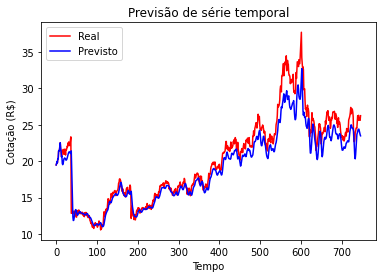

In [128]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [129]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.031633200664391


In [130]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 4.127533462041838


In [131]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 6.432164766442663 %


In [132]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.8320371785182525


In [133]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.8316985437975233


In [134]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [135]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [136]:
results = np.column_stack((results, data))

In [137]:
print(results)

[[100.         100.         100.         100.         100.
  100.        ]
 [ 60.          60.          60.          80.          80.
   80.        ]
 [ 30.          50.          70.          30.          50.
   70.        ]
 [  2.38163629   2.12167942   2.31794806   1.64831748   2.06928729
    2.0316332 ]
 [  5.67219143   4.50152357   5.37288321   2.71695051   4.28194989
    4.12753346]
 [  6.94875519   6.56662305   6.91097834   4.6900769    6.21236101
    6.43216477]
 [  0.76918      0.8168183    0.78135983   0.88943841   0.82575347
    0.83203718]
 [  0.76871464   0.81644898   0.78091902   0.8892155    0.82540217
    0.83169854]]


### Parâmetros para esta análise

In [138]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 100
units2 = 100
units3 = 30

### Normalização

In [139]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [140]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [141]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [142]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [143]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [144]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [145]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 15, 100)           40800     
_________________________________________________________________
dropout_18 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 15, 100)           80400     
_________________________________________________________________
dropout_19 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 30)                15720     
_________________________________________________________________
dropout_20 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

### Treinamento

In [146]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0962
Epoch 2/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0386
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0249
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0332
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0260
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0241
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0214
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0187
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0211
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0190
Epoch 11/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0194
Epoch 12/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0181
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [147]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [148]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [149]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

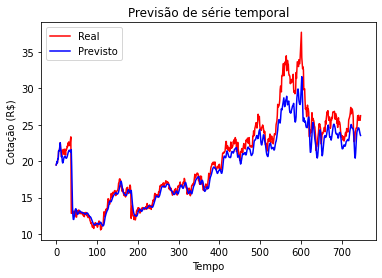

In [150]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [151]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.105287817422405


In [152]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 4.432236794187194


In [153]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 6.108666482609456 %


In [154]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.819637804448319


In [155]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.8192741709895455


In [156]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [157]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [158]:
results = np.column_stack((results, data))

In [159]:
print(results)

[[100.         100.         100.         100.         100.
  100.         100.        ]
 [ 60.          60.          60.          80.          80.
   80.         100.        ]
 [ 30.          50.          70.          30.          50.
   70.          30.        ]
 [  2.38163629   2.12167942   2.31794806   1.64831748   2.06928729
    2.0316332    2.10528782]
 [  5.67219143   4.50152357   5.37288321   2.71695051   4.28194989
    4.12753346   4.43223679]
 [  6.94875519   6.56662305   6.91097834   4.6900769    6.21236101
    6.43216477   6.10866648]
 [  0.76918      0.8168183    0.78135983   0.88943841   0.82575347
    0.83203718   0.8196378 ]
 [  0.76871464   0.81644898   0.78091902   0.8892155    0.82540217
    0.83169854   0.81927417]]


### Parâmetros para esta análise

In [160]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 100
units2 = 100
units3 = 50

### Normalização

In [161]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [162]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [163]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [164]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [165]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [166]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [167]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 15, 100)           40800     
_________________________________________________________________
dropout_21 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 15, 100)           80400     
_________________________________________________________________
dropout_22 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_23 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

### Treinamento

In [168]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0975
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0413
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0301
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0307
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0262
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0232
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0225
Epoch 8/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0198
Epoch 9/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0208
Epoch 10/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0191
Epoch 11/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0173
Epoch 12/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0163
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [169]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [170]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [171]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

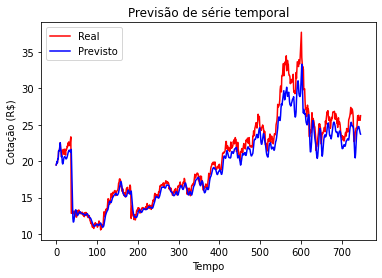

In [172]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [173]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 1.8071625952109587


In [174]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 3.2658366455296073


In [175]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 5.617459402981927 %


In [176]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.8671024371997984


In [177]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.8668344985651206


In [178]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [179]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [180]:
results = np.column_stack((results, data))

In [181]:
print(results)

[[100.         100.         100.         100.         100.
  100.         100.         100.        ]
 [ 60.          60.          60.          80.          80.
   80.         100.         100.        ]
 [ 30.          50.          70.          30.          50.
   70.          30.          50.        ]
 [  2.38163629   2.12167942   2.31794806   1.64831748   2.06928729
    2.0316332    2.10528782   1.8071626 ]
 [  5.67219143   4.50152357   5.37288321   2.71695051   4.28194989
    4.12753346   4.43223679   3.26583665]
 [  6.94875519   6.56662305   6.91097834   4.6900769    6.21236101
    6.43216477   6.10866648   5.6174594 ]
 [  0.76918      0.8168183    0.78135983   0.88943841   0.82575347
    0.83203718   0.8196378    0.86710244]
 [  0.76871464   0.81644898   0.78091902   0.8892155    0.82540217
    0.83169854   0.81927417   0.8668345 ]]


### Parâmetros para esta análise

In [182]:
pwindow = 15
pepochs3 = 100
pbatch2 = 64

units1 = 100
units2 = 100
units3 = 70

### Normalização

In [183]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [184]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [185]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [186]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [187]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [188]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [189]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = units1, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = units2, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = units3))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 15, 100)           40800     
_________________________________________________________________
dropout_24 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 15, 100)           80400     
_________________________________________________________________
dropout_25 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 70)                47880     
_________________________________________________________________
dropout_26 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

### Treinamento

In [190]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch2)

Epoch 1/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0696
Epoch 2/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0313
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0254
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0228
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0224
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0183
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0187
Epoch 8/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0169
Epoch 9/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0171
Epoch 10/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0163
Epoch 11/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0177
Epoch 12/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0147
Epoch 13/100
4/4 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [191]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [192]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [193]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

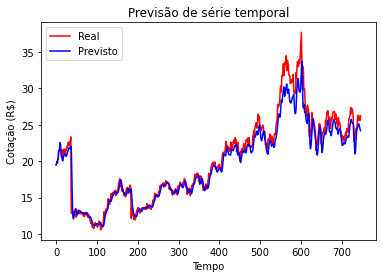

In [194]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [195]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 1.5139120638559793


In [196]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 2.291929737088671


In [197]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 4.372578801642135 %


In [198]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.906733891119347


In [199]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.906545854609507


In [200]:
# results = np.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [201]:
data = pd.array([units1,units2,units3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [202]:
results = np.column_stack((results, data))

In [203]:
print(results)

[[100.         100.         100.         100.         100.
  100.         100.         100.         100.        ]
 [ 60.          60.          60.          80.          80.
   80.         100.         100.         100.        ]
 [ 30.          50.          70.          30.          50.
   70.          30.          50.          70.        ]
 [  2.38163629   2.12167942   2.31794806   1.64831748   2.06928729
    2.0316332    2.10528782   1.8071626    1.51391206]
 [  5.67219143   4.50152357   5.37288321   2.71695051   4.28194989
    4.12753346   4.43223679   3.26583665   2.29192974]
 [  6.94875519   6.56662305   6.91097834   4.6900769    6.21236101
    6.43216477   6.10866648   5.6174594    4.3725788 ]
 [  0.76918      0.8168183    0.78135983   0.88943841   0.82575347
    0.83203718   0.8196378    0.86710244   0.90673389]
 [  0.76871464   0.81644898   0.78091902   0.8892155    0.82540217
    0.83169854   0.81927417   0.8668345    0.90654585]]


In [204]:
my_df = pd.DataFrame(results)

In [205]:
my_df.to_csv('results_LSTM5.csv', index=False)